In [1]:
# Imports
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel

In [3]:
import calendar
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

In [11]:
# Get a list of column names and types for "station"
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Get a list of column names and types for "measurement"
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Climate Analysis and Exploration

## Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

In [13]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement).order_by(Measurement.date.desc()).first().date
first_date = (pd.to_datetime(last_date) - timedelta(days=365)).date()
print(f'Last Date Recorded: {last_date}\nDate one year before: {first_date}')

Last Date Recorded: 2017-08-23
Date one year before: 2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
datas = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= first_date)

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(datas, columns=['Dates', 'Precipitations'])
df.set_index('Dates', inplace=True)
df = df.sort_values(['Dates'])

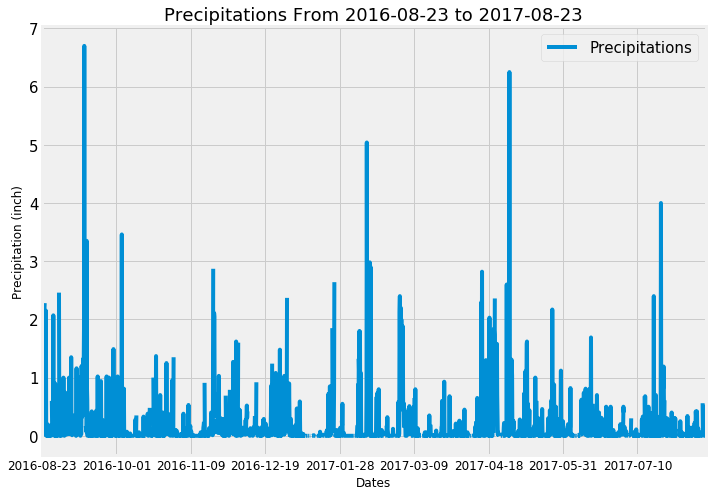

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot.line(fontsize = 12, figsize=(10,7))
plt.ylabel('Precipitation (inch)')
plt.title(label=f'Precipitations From {first_date} to {last_date}', fontsize = 18)
plt.tick_params(labelsize = 15, axis="y",direction="in")
plt.legend(loc='best', prop={'size': 15})
plt.tight_layout()
plt.savefig("Figures/precipitations_one_year.png")
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitations
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

* Design a query to calculate the total number of stations.

In [18]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(Measurement.station).\
    group_by(Measurement.station).count()
print("{} stations are available in this dataset.".format(count_stations))

9 stations are available in this dataset.


* Design a query to find the most active stations.
    * List the stations and observation counts in descending order.

In [19]:
# Design a query to get the stations and their observations count
active_stations = session.query(Station.name, Measurement.station, func.count(Measurement.station)).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()                                 

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the station ID column
active_df = pd.DataFrame(active_stations, columns=["Station Name", "Station ID", "Observations Count"])
active_df.set_index("Station ID", inplace=True)
active_df

,Station Name,Observations Count
Station ID,,
USC00519281,"WAIHEE 837.5, HI US",2772
USC00519397,"WAIKIKI 717.2, HI US",2724
USC00513117,"KANEOHE 838.1, HI US",2709
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
USC00517948,"PEARL CITY, HI US",1372
USC00518838,"UPPER WAHIAWA 874.3, HI US",511


* Which station has the highest number of observations?

In [21]:
# Design a query to find the most active station
most_active= session.query(Station.name, Measurement.station, func.count(Measurement.station)).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).first()  

In [22]:
print("The station {} (ID:{}) has the highest number of observations with {} observations.".\
      format(most_active[0], most_active[1], most_active[2]))

The station WAIHEE 837.5, HI US (ID:USC00519281) has the highest number of observations with 2772 observations.


* For the station with the highest number of observations, calculate:
    * lowest, highest and average temperature recorded

In [23]:
# Design a query to get the lowest, highest and average temperature recorded for the most active station
query_temp = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active[1]).all()

records = ["lowest", "average", "highest"]
for results in query_temp:
    for i in range(len(results)):
        print(f"The {records[i]} temperature recorded in {most_active[0]} is {results[i]:.1f}° F")

The lowest temperature recorded in WAIHEE 837.5, HI US is 54.0° F
The average temperature recorded in WAIHEE 837.5, HI US is 71.7° F
The highest temperature recorded in WAIHEE 837.5, HI US is 85.0° F


* Design a query to retrieve the last 12 months of temperature observation data (tobs) for the most active station

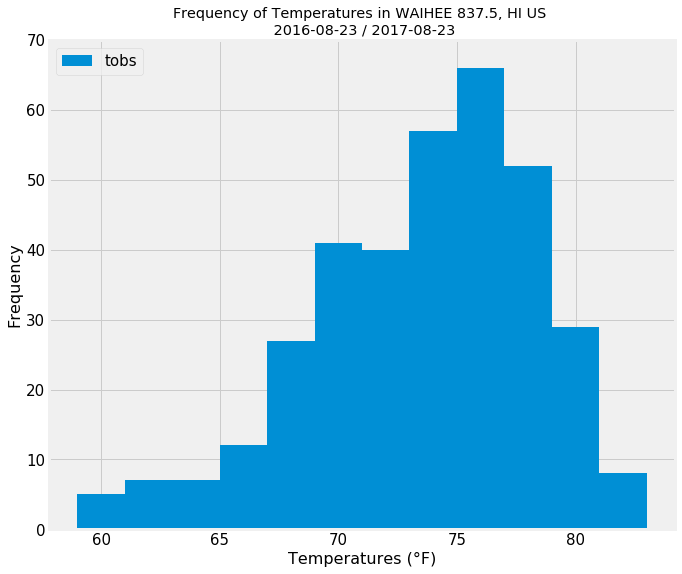

In [24]:
# Query the last 12 months of temperature observation data for the station with the highest number of temperature observations.
twelve_months = session.query(Measurement.tobs).\
    filter((Measurement.station == most_active[1]), (Measurement.date > first_date)).all()

# Convert the query results in a DataFrame
df_twelve = pd.DataFrame(twelve_months)

# Plot the results as a histogram
df_twelve.plot.hist(bins=12, title=f"Frequency of Temperatures in {most_active[0]} \n {first_date} / {last_date}",
                   figsize=(10,9))
plt.tick_params(labelsize = 15, direction="in")
plt.legend(loc=2, prop={'size': 15})

plt.ylabel('Frequency', fontsize=16)
plt.ylim((0,70))
plt.xlabel('Temperatures (°F)', fontsize=16)
plt.savefig("Figures/Frequency_temperatures_oneyear.png")
plt.show()


## Temperature Analysis I

Identify the average temperature in June and December at all stations across all available years in the dataset.

In [25]:
# Create a function which return a list of temperatures for the month chosen by the user
def monthly_list(month_number):
    """Monthly List.
    
    Args:
        month_number (str): A date string in the format '%m'
        
    Returns:
        A list of temperatures for this month at all stations across all available years in the dataset.
    
    """
    return session.query(Measurement.tobs).\
                         filter(func.strftime("%m", Measurement.date) == month_number).all()

In [26]:
# Ask the user which two months have to be to compare (June and December in this case) 
while True:
    try:
        number_month1 = input("First month in format MM ?   ")
        print(f'Month of {calendar.month_name[int(number_month1)]} selected')
        number_month2 = input("Second month in format MM ?   ")
        print(f'Month of {calendar.month_name[int(number_month2)]} selected')
        break
    except (ValueError, IndexError):
        print(f'Input {number_month1} does not match format MM (e.g. 01 for January)')

# Calculate the mean for each of both months
means_month1 = np.mean(monthly_list(number_month1))
means_month2 = np.mean(monthly_list(number_month2))

# Print the average temperature at all stations across all available years in the dataset for both months.
print(f"The average temperature for {calendar.month_name[int(number_month1)]} is {means_month1:.1f} \
and {means_month2:.1f} for {calendar.month_name[int(number_month2)]}.")

First month in format MM ?   06
Month of June selected
Second month in format MM ?   12
Month of December selected
The average temperature for June is 74.9 and 71.0 for December.


In order to determine whether the difference in the means is statistically significant, the unpaired t-test (Student t-test) has been chosen. Even if we have records from the same stations, we don't have the same number of records in each of these two months.

In [27]:
# t-test
(t_stat, p) = ttest_ind(monthly_list(number_month1), monthly_list(number_month2), equal_var=False)
print(f't-stat = {t_stat} ; p = {p}')
if p < 0.001:
    print(f"The differences of means between {calendar.month_name[int(number_month1)]} \
and {calendar.month_name[int(number_month2)]} ARE statistically highly significant.")
    
elif p < 0.05:
    print(f"The differences of means between {calendar.month_name[int(number_month1)]} \
and {calendar.month_name[int(number_month2)]} ARE statistically significant.")
    
else:
    print(f"The differences of means between {calendar.month_name[int(number_month1)]} \
and {calendar.month_name[int(number_month2)]} ARE NOT statistically significant.")

t-stat = [31.35503692] ; p = [4.19352984e-187]
The differences of means between June and December ARE statistically highly significant.


## Temperature Analysis II

Calculate the min, avg, and max temperatures for the trip using the last matching dates available in the dataset (i.e., use "2017-01-01" if your trip start date will be "2020-01-01").

In [28]:
# Ask the user about the trip start date and how many days of holidays in order to calculate the last matching dates
while True:
    try:
        start_trip = input("Trip start in MM/DD/YYYY format?   ") # Define the trip start date with the user's input
        
        start_trip = (pd.to_datetime(start_trip)).date() # Convert the input in datetime format
        
        if start_trip > dt.date.today() : # If the date chosen is after today, OK
            start_trip1 = start_trip.strftime("%a %d %b, %Y") # Convert the date format with day name 
            print(start_trip1) # Print the new format         
            break
        
        # If not, return to the input
        else:
            print('The date has passed')
    except ValueError: # If the date doesn't match the format asked
        print(f'time data {start_trip} does not match format MM/DD/YYYY')

while True:
    try:
        # Ask the number of days of holidays
        number_days = int(input("How many days?   "))
        # If  <= 3 number <= 15, OK 
        if 3 <= number_days <= 15:
            print('Enjoy!')
            break
        
        # If not, return to the input
        else:
            print('Make sure that your vacation range is approximately 3-15 days total')
    
    except ValueError: # If the date doesn't match the format asked
        print(f'{number_days} is not a digit - please try again.') 

# Calculate the end trip date
end_trip = (start_trip + timedelta(days=number_days))

# Convert the end trip date format with day name 
end_trip1 = end_trip.strftime("%a %d %b, %Y")

# Print the trip dates
print(f"You plan to go to Honolulu, Hawaii from {start_trip1} to {end_trip1}")

Trip start in MM/DD/YYYY format?   07/14/2021
Wed 14 Jul, 2021
How many days?   7
Enjoy!
You plan to go to Honolulu, Hawaii from Wed 14 Jul, 2021 to Wed 21 Jul, 2021


In [29]:
# Find the last matching dates availables

# While the match end trip date for the previous year is not in the dataset (> last date in the dataset)
counter_year = 1 # Create the counter for year
while (pd.to_datetime(end_trip)- timedelta(days= counter_year*365.25) > (pd.to_datetime(last_date))):

    #counter + 1
    counter_year +=1

# When the matching last day trip
else:
    # Calculate the matching start and end date trip 
    start_date = (pd.to_datetime(start_trip)- timedelta(days=counter_year*365.25)).date()
    end_date = (pd.to_datetime(end_trip)- timedelta(days=counter_year*365.25)).date()

In [30]:
# Print the dayes selected to query
print(f"Period used to query will be: {start_date} to {end_date}")

Period used to query will be: 2017-07-14 to 2017-07-21


In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
   # Return the minimum, average, and maximum temperatures for the range of dates 
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the last matching data for those same dates.
print(f"Between {start_date} and {end_date}:")
for results in calc_temps(start_date, end_date):
    for i in range(len(results)):
        print(f"The {records[i]} temperature recorded is {results[i]:.1f}° F")

Between 2017-07-14 and 2017-07-21:
The lowest temperature recorded is 72.0° F
The average temperature recorded is 78.6° F
The highest temperature recorded is 83.0° F


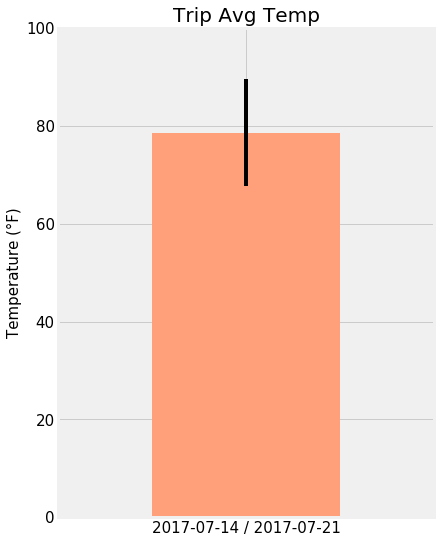

In [33]:
# Plot the results from your previous query as a bar chart. 
plt.figure(figsize=(6,9))
x = (f"{start_date} / {end_date}")
plt.bar(x, results[1], width=0.5, align='center', yerr = (results[2]-results[0]), color='lightsalmon')
plt.title('Trip Avg Temp', fontsize = 20)
plt.ylabel('Temperature (°F)', fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xlim(-0.5,0.5)
plt.ylim(0,100)
plt.savefig("Figures/Trip_avg_temp.png")
plt.show()

## Daily Rainfall Average
Calculate the rainfall per weather station using the previous year's matching dates.


In [36]:
# Select the values we are interested for
sel = [Station.station, Station.name, Station.latitude, 
   Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

# Query the selection, join the precipitation from Measurement table with the filter and select the period
rainfall = session.query(*sel).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all() 

In [37]:
# Build a DataFrame with the previous query and set the index on Station ID
rainfall_df = pd.DataFrame(rainfall, columns=['Station ID', 'Station Name', 'Latitude', 'Longitude',
                                              'Elevation', f'Precipitations {start_date} / {end_date}'])
rainfall_df.set_index(['Station ID'])

,Station Name,Latitude,Longitude,Elevation,Precipitations 2017-07-14 / 2017-07-21
Station ID,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,5.14
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.75
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.42
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.38
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.33
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.15
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


## Optional Challenge Assignment

Calculate the daily normals for the trip

In [38]:
# Create a query that will calculate the daily normals
def daily_normals(date):
    """Daily Normals.
    Args:
        date (str): A date string in the format '%m-%d'
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [39]:
# Create a list for the the range of dates
dates_m_d = []
datesmd = []
# Use the start and number days to create a range of dates
for i in range(number_days+1):
    date_trip = ((start_date) + timedelta(days=i))
    dates_m_d.append(date_trip.strftime("%m-%d")) # Stip off the year and save a list of %m-%d strings
    datesmd.append(date_trip.strftime("%d %B"))
# Create a list of daily normals 
normals = []

# Loop through the list of %m-%d strings and calculate the normals and put them into the list
for dates in dates_m_d:
    normals.append(daily_normals(dates))

In [40]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin = [(value[0][0]) for value in normals]
tavg = [(value[0][1]) for value in normals]
tmax = [(value[0][2]) for value in normals]

df = pd.DataFrame({"Date": datesmd, "T.min": tmin, "T.avg": tavg, "T.max": tmax}).set_index("Date")

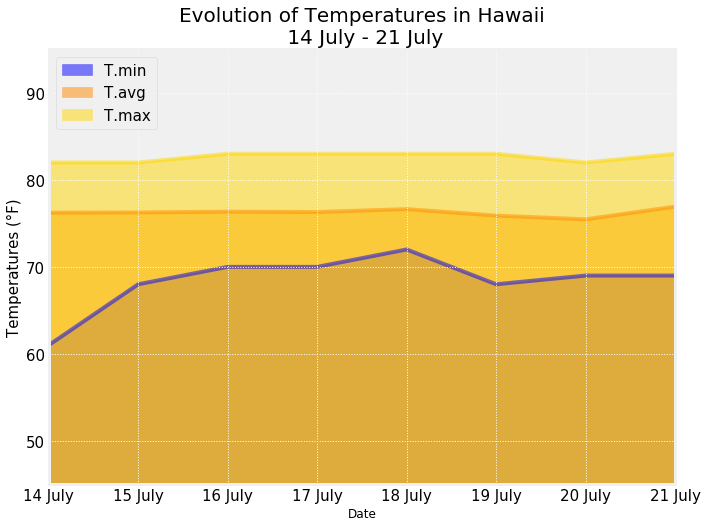

In [41]:
start = start_date.strftime("%d %B")
end = end_date.strftime("%d %B")
# Plot the daily normals as an area plot with `stacked=False`
pal = ["blue", "darkorange", "gold"]
df.plot.area(stacked=False, figsize=(10,8), zorder=0, color=pal, alpha=0.5 )
plt.ylabel('Temperatures (°F)', fontsize = 15)
plt.title(f'Evolution of Temperatures in Hawaii\n {start} - {end}', fontsize = 20)
plt.ylim(45,95)
plt.legend(loc=2, prop={'size': 15})
#ax.xaxis.grid(which='minor', color='black', linestyle='dotted', linewidth=0.5)
plt.grid(color='white', linestyle='dotted', linewidth=1, zorder=5)

plt.tick_params(labelsize = 15)

# create your palette
#pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
#plt.stackplot(x,y, labels=['A','B','C'], colors=pal, alpha=0.4 )
#plt.legend(loc='upper right')

plt.savefig("Figures/Evolution_temperatures.png")
plt.show()